As my last assignment from Sport Data Analytics course I would like to choose the GUST_boxing_classification dataset to apply several machine learning classification models on it. As in the article[1] of this source was mentioned,
I would use the whole data as sensor configuration 2, where the user not only weares sensor on third thoracic vertebrae, but also on both wrists in a special pair of gloves to detect box punches. This way we can classify types of strikes.


Worsey, Matthew T.O.; Espinosa, Hugo G.; Shepherd, Jonathan B.; Thiel, David V. 2020. "An Evaluation of Wearable Inertial Sensor Configuration and Supervised Machine Learning Models for Automatic Punch Classification in Boxing" IoT 1, no. 2: 360-381. https://doi.org/10.3390/iot1020021

In [1]:
import pandas as pd
import numpy as np
import zipfile
import warnings

warnings.filterwarnings('ignore')



In [2]:
# I am using raw data file as I can be sure there are all three sensors' data:
filename="gust_boxing.zip"
df_raw_left=pd.read_excel(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Raw_sensor_training_data.xlsx"),sheet_name="Left wrist")
df_raw_right=pd.read_excel(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Raw_sensor_training_data.xlsx"),sheet_name="Right wrist")
df_raw_t3=pd.read_excel(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Raw_sensor_training_data.xlsx"),sheet_name="Upper back (T3)")

First, I would like to make a data representation and pre-processing

In [3]:
df_raw_left.drop('Sample_rate (Hz)', axis='columns', inplace=True)
df_raw_left.dropna()
df_raw_right.drop('Sample_rate (Hz)', axis='columns', inplace=True)
df_raw_right.dropna()
df_raw_left.head()

,Accel_x (g),Accel_y (g),Accel_z (g),Gyro_x (deg/s),Gyro_y (deg/s,Gyro_z (deg/s,Roll (rad),Pitch (rad),Yaw (rad)
0,0.902832,-0.353027,-0.229492,-1.341463,-2.865854,0.670732,-0.010407,-0.016146,-0.006142
1,0.902832,-0.356445,-0.238770,-1.646341,-2.926829,0.548780,-0.020827,-0.032318,-0.012059
2,0.897949,-0.353027,-0.235352,-1.524390,-2.865854,0.792683,-0.028291,-0.047797,-0.022268
3,0.900391,-0.350098,-0.231934,-1.646341,-2.926829,1.097561,-0.035675,-0.063366,-0.032244
4,0.900879,-0.350098,-0.233398,-1.524390,-2.926829,0.853659,-0.043032,-0.078995,-0.041999


In [4]:
print(len(df_raw_t3))
df_raw_t3.drop('Sample_rate (Hz)', axis='columns', inplace=True)
df_raw_t3.dropna()
df_raw_t3.head()

167935


,Accel_x (g),Accel_y (g),Accel_z (g),Gyro_x (deg/s),Gyro_y (deg/s,Gyro_z (deg/s,Roll (rad),Pitch (rad),Yaw (rad)
0,-0.914062,0.107422,-0.455566,-0.914062,0.107422,-0.455566,-1.768293,0.365854,-0.914634
1,-0.919434,0.101562,-0.461426,-0.919434,0.101562,-0.461426,-2.012195,0.304878,-0.792683
2,-0.911133,0.106934,-0.454590,-0.911133,0.106934,-0.454590,-1.951220,0.243902,-0.609756
3,-0.923828,0.103516,-0.445801,-0.923828,0.103516,-0.445801,-1.951220,0.243902,-0.731707
4,-0.914062,0.105957,-0.454102,-0.914062,0.105957,-0.454102,-2.195122,0.304878,-0.792683


In [5]:
df_types_from_video=pd.read_excel(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Punch_orders_video_analysis.xlsx"))
print(len(df_types_from_video))
df_types_from_video

250


,Training_session,Evaluation_session
0,Left_jab,Right Cross
1,Left_jab,Left Jab
2,Left_jab,Left Jab
3,Left_jab,Right Upper Cut
4,Left_jab,Left Hook
...,...,...
245,Right_uppercut,NaN
246,Right_uppercut,NaN
247,Right_uppercut,NaN
248,Right_uppercut,NaN


In [14]:
# 1: it seems only the first 250 punches were observed and labeled, so I need to cut data there
# 2: I need more features as in the other prepared data files
# 3: need to merge all 4 datasets
# 4: need to take only the 'Training_session' column as y
# 5: I already do not care about Sample_rate column, and needed to drop from all 3 input data
#all3 = [df_raw_left, df_raw_right, df_raw_t3]
def calc_features(df_raw):
  list_of_features = list()
  # instances = pd.DataFrame(columns=["Ax_mean","Ax_std","Ax_min","Ax_max","Ax_kurtosis","Ax_skew","Ay_mean","Ay_std","Ay_min","Ay_max","Ay_kurtosis","Ay_skew","Az_mean","Az_std","Az_min","Az_max","Az_kurtosis","Gx_mean","Gx_std","Gx_min","Gx_max","Gx_kurtosis","Gy_mean","Gy_std","Gy_min","Gy_max","Gy_kurtosis","Gz_mean","Gz_std","Gz_min","Gz_max","Gz_kurtosis","Roll_mean","Roll_std","Roll_min","Roll_max","Roll_kurtosis","Pitch_mean","Pitch_std","Pitch_min","Pitch_max","Pitch_kurtosis","Yaw_mean","Yaw_std","Yaw_min","Yaw_max","Yaw_kurtosis"])
  for i in range(250):
    features={}
    #for i in range(300):
    start = i*300
    end =((i+1)*300)-1
    features["Ax_mean"]=df_raw["Accel_x (g)"].iloc[start:end].mean()
    features["Ax_std"]=df_raw["Accel_x (g)"].iloc[start:end].std()
    features["Ax_min"]=df_raw["Accel_x (g)"].iloc[start:end].min()
    features["Ax_max"]=df_raw["Accel_x (g)"].iloc[start:end].max()
    features["Ax_kurtosis"]=df_raw["Accel_x (g)"].iloc[start:end].kurtosis()
    features["Ax_skew"]=df_raw["Accel_x (g)"].iloc[start:end].skew()

    features["Ay_mean"]=df_raw["Accel_y (g)"].iloc[start:end].mean()
    features["Ay_std"]=df_raw["Accel_y (g)"].iloc[start:end].std()
    features["Ay_min"]=df_raw["Accel_y (g)"].iloc[start:end].min()
    features["Ay_max"]=df_raw["Accel_y (g)"].iloc[start:end].max()
    features["Ay_kurtosis"]=df_raw["Accel_y (g)"].iloc[start:end].kurtosis()
    features["Ay_skew"]=df_raw["Accel_y (g)"].iloc[start:end].skew()

    features["Az_mean"]=df_raw["Accel_z (g)"].iloc[start:end].mean()
    features["Az_std"]=df_raw["Accel_z (g)"].iloc[start:end].std()
    features["Az_min"]=df_raw["Accel_z (g)"].iloc[start:end].min()
    features["Az_max"]=df_raw["Accel_z (g)"].iloc[start:end].max()
    features["Az_kurtosis"]=df_raw["Accel_z (g)"].iloc[start:end].kurtosis()
    features["Az_skew"]=df_raw["Accel_z (g)"].iloc[start:end].skew()

    features["Gx_mean"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].mean()
    features["Gx_std"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].std()
    features["Gx_min"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].min()
    features["Gx_max"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].max()
    features["Gx_kurtosis"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].kurtosis()
    features["Gx_skew"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].skew()

    features["Gy_mean"]=df_raw["Gyro_y (deg/s"].iloc[start:end].mean()
    features["Gy_std"]=df_raw["Gyro_y (deg/s"].iloc[start:end].std()
    features["Gy_min"]=df_raw["Gyro_y (deg/s"].iloc[start:end].min()
    features["Gy_max"]=df_raw["Gyro_y (deg/s"].iloc[start:end].max()
    features["Gy_kurtosis"]=df_raw["Gyro_y (deg/s"].iloc[start:end].kurtosis()
    features["Gy_skew"]=df_raw["Gyro_y (deg/s"].iloc[start:end].skew()

    features["Gz_mean"]=df_raw["Gyro_z (deg/s"].iloc[start:end].mean()
    features["Gz_std"]=df_raw["Gyro_z (deg/s"].iloc[start:end].std()
    features["Gz_min"]=df_raw["Gyro_z (deg/s"].iloc[start:end].min()
    features["Gz_max"]=df_raw["Gyro_z (deg/s"].iloc[start:end].max()
    features["Gz_kurtosis"]=df_raw["Gyro_z (deg/s"].iloc[start:end].kurtosis()
    features["Gz_skew"]=df_raw["Gyro_z (deg/s"].iloc[start:end].skew()

    features["Roll_mean"]=df_raw["Roll (rad)"].iloc[start:end].mean()
    features["Roll_std"]=df_raw["Roll (rad)"].iloc[start:end].std()
    features["Roll_min"]=df_raw["Roll (rad)"].iloc[start:end].min()
    features["Roll_max"]=df_raw["Roll (rad)"].iloc[start:end].max()
    features["Roll_kurtosis"]=df_raw["Roll (rad)"].iloc[start:end].kurtosis()
    features["Roll_skew"]=df_raw["Roll (rad)"].iloc[start:end].skew()

    features["Pitch_mean"]=df_raw["Pitch (rad)"].iloc[start:end].mean()
    features["Pitch_std"]=df_raw["Pitch (rad)"].iloc[start:end].std()
    features["Pitch_min"]=df_raw["Pitch (rad)"].iloc[start:end].min()
    features["Pitch_max"]=df_raw["Pitch (rad)"].iloc[start:end].max()
    features["Pitch_kurtosis"]=df_raw["Pitch (rad)"].iloc[start:end].kurtosis()
    features["Pitch_skew"]=df_raw["Pitch (rad)"].iloc[start:end].skew()

    features["Yaw_mean"]=df_raw["Yaw (rad)"].iloc[start:end].mean()
    features["Yaw_std"]=df_raw["Yaw (rad)"].iloc[start:end].std()
    features["Yaw_min"]=df_raw["Yaw (rad)"].iloc[start:end].min()
    features["Yaw_max"]=df_raw["Yaw (rad)"].iloc[start:end].max()
    features["Yaw_kurtosis"]=df_raw["Yaw (rad)"].iloc[start:end].kurtosis()
    features["Yaw_skew"]=df_raw["Yaw (rad)"].iloc[start:end].skew()
    list_of_features.append(features)
  instances = pd.DataFrame(list_of_features)
  return instances


f1 = calc_features(df_raw_left)
f2 = calc_features(df_raw_right)
f3 = calc_features(df_raw_t3)
f1.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresLeft.csv')
f2.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresRight.csv')
f3.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresT3.csv')
f1

,Ax_mean,Ax_std,Ax_min,Ax_max,Ax_kurtosis,Ax_skew,Ay_mean,Ay_std,Ay_min,Ay_max,...,Pitch_min,Pitch_max,Pitch_kurtosis,Pitch_skew,Yaw_mean,Yaw_std,Yaw_min,Yaw_max,Yaw_kurtosis,Yaw_skew
0,0.808221,0.197954,0.196777,0.971680,2.439069,-1.941614,-0.504130,0.220754,-0.928711,-0.333984,...,-1.232649,-0.016146,-1.014384,0.583731,0.300546,0.315955,-0.259155,0.643235,-1.076220,-0.742528
1,0.345130,0.084746,0.188477,0.510254,-1.081262,-0.079611,-0.880151,0.069658,-1.003906,-0.700195,...,-0.245736,-0.044918,-0.890603,0.424705,0.304220,0.057896,0.232581,0.435077,-0.674729,0.624037
2,0.690021,0.225914,0.247070,0.912598,-1.072459,-0.702378,-0.669577,0.210904,-1.024902,-0.403809,...,-1.067787,-0.252961,-1.265295,0.451409,0.310719,0.070875,0.199343,0.440653,-1.006480,0.142493
3,0.898256,0.008278,0.863770,0.916992,3.304826,-1.398078,-0.385371,0.030710,-0.437012,-0.328613,...,-1.157147,-1.065796,-0.438135,-0.351127,0.387535,0.009416,0.358712,0.400929,0.551185,-0.981890
4,0.844322,0.078760,0.694336,0.949219,-1.314814,-0.475445,-0.464927,0.109982,-0.677246,-0.320801,...,-1.175515,-0.817281,-1.590979,0.359117,0.247735,0.091301,0.095096,0.357429,-1.431235,-0.544958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-0.763709,0.688646,-2.469238,1.437500,2.401738,0.978220,-0.291238,0.404741,-0.961914,0.469727,...,0.107001,1.241449,-0.647281,-0.807595,0.433086,0.706343,-0.606825,1.750042,-0.802072,0.360224
246,-0.126819,2.423823,-4.838379,15.999512,8.138734,1.637033,-1.247609,1.858926,-14.378418,5.043945,...,-0.148602,0.654381,-1.221497,-0.361869,0.564783,0.899243,-0.658358,2.222206,-1.257087,0.201329
247,-0.268906,2.533593,-5.114746,14.752441,6.568804,1.760352,-1.059092,1.926948,-15.229980,6.800293,...,-0.029460,1.171704,-0.547489,-0.140887,0.753655,1.180580,-0.635848,2.368485,-1.710987,0.143015
248,-0.629231,2.512281,-5.095703,15.999512,8.064151,1.964692,-0.807054,1.995297,-14.793945,2.696289,...,-0.019059,1.264650,-1.542912,-0.339178,0.445083,0.837285,-0.624428,1.872388,-1.286227,0.466999


In [ ]:
f1 = pd.read_csv("/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresLeft.csv")
f2 = pd.read_csv("/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresRight.csv")
f3 = pd.read_csv("/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresT3.csv")

In [ ]:
f1

In [16]:
joined1 = pd.merge(f1, f2, left_index=True, right_index=True)
inputData = pd.merge(joined1, f3, left_index=True, right_index=True)
inputData = inputData.dropna()
#inputData=inputData.drop(inputData.columns[[0]],axis = 1)
#inputData.drop(columns=['Unnamed: 0_y', 'Unnamed: 0'], inplace=True)

In [17]:
inputData.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/box_inputs.csv')
inputData

,Ax_mean_x,Ax_std_x,Ax_min_x,Ax_max_x,Ax_kurtosis_x,Ax_skew_x,Ay_mean_x,Ay_std_x,Ay_min_x,Ay_max_x,...,Pitch_min,Pitch_max,Pitch_kurtosis,Pitch_skew,Yaw_mean,Yaw_std,Yaw_min,Yaw_max,Yaw_kurtosis,Yaw_skew
0,0.808221,0.197954,0.196777,0.971680,2.439069,-1.941614,-0.504130,0.220754,-0.928711,-0.333984,...,0.060976,5.243902,0.090595,1.097907,-4.493229,5.964180,-16.158537,-0.121951,-0.787140,-1.014239
1,0.345130,0.084746,0.188477,0.510254,-1.081262,-0.079611,-0.880151,0.069658,-1.003906,-0.700195,...,-2.865854,8.841463,-0.856676,0.476855,0.231259,4.790989,-12.317073,9.451220,-0.364939,0.021367
2,0.690021,0.225914,0.247070,0.912598,-1.072459,-0.702378,-0.669577,0.210904,-1.024902,-0.403809,...,-5.182927,9.085366,-0.770953,0.810447,3.297169,5.119542,-4.451220,12.317073,-1.241900,0.282560
3,0.898256,0.008278,0.863770,0.916992,3.304826,-1.398078,-0.385371,0.030710,-0.437012,-0.328613,...,-8.719512,7.560976,-1.260934,0.410841,7.702708,4.517398,-2.317073,13.658537,-0.842269,-0.488987
4,0.844322,0.078760,0.694336,0.949219,-1.314814,-0.475445,-0.464927,0.109982,-0.677246,-0.320801,...,-9.573171,7.560976,1.600713,1.246925,-1.457705,2.409689,-5.060976,4.329268,0.597660,1.233336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-0.763709,0.688646,-2.469238,1.437500,2.401738,0.978220,-0.291238,0.404741,-0.961914,0.469727,...,-20.243902,34.634146,-1.212074,-0.174324,-44.835835,55.835561,-133.719512,91.951220,-0.638365,0.166974
246,-0.126819,2.423823,-4.838379,15.999512,8.138734,1.637033,-1.247609,1.858926,-14.378418,5.043945,...,-62.134146,77.865854,-0.715804,-0.399863,2.734929,122.134299,-130.853659,301.280488,-0.631098,0.853179
247,-0.268906,2.533593,-5.114746,14.752441,6.568804,1.760352,-1.059092,1.926948,-15.229980,6.800293,...,-83.475610,28.902439,1.707780,-1.244758,31.493597,105.995146,-117.439024,253.841463,-0.969121,0.334842
248,-0.629231,2.512281,-5.095703,15.999512,8.064151,1.964692,-0.807054,1.995297,-14.793945,2.696289,...,-83.780488,42.560976,0.074986,-0.824860,34.618444,95.984538,-93.719512,280.243902,-0.427799,0.823065


In [ ]:
#inputData = pd.read_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/box_inputs.csv')

In [ ]:
# get the labels for supervised machine learning: classes for classification
filename="gust_boxing.zip"

df_y=pd.read_excel(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Punch_orders_video_analysis.xlsx"))
print(df_y.head())

df_y.drop('Evaluation_session', axis='columns', inplace=True)
df_y.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/box_outputs.csv')
#df_y = pd.read_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/box_outputs.csv')
df_y

,Training_session
0,Left_jab
1,Left_jab
2,Left_jab
3,Left_jab
4,Left_jab
...,...
245,Right_uppercut
246,Right_uppercut
247,Right_uppercut
248,Right_uppercut


In [ ]:
# I need to split data for training and testing as well:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputData, df_y, test_size=0.2, random_state=42)

In [ ]:
# Now I would start machine learning with Logistic regression, but before let's do a cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

reg_model = LogisticRegression()
results=cross_validate(reg_model,X_train,y_train,cv=10,scoring='accuracy')


In [ ]:
print("results:", results['test_score'])
print("mean score:", np.mean(results['test_score']))
print("standardd deviation:", np.std(results['test_score']))

results: [0.2  0.25 0.25 0.25 0.2  0.2  0.2  0.2  0.2  0.2 ]
mean score: 0.215
standardd deviation: 0.022912878474779193


In [ ]:
# now I fit data and predict based on the model. Then I can check the accuracy
reg_model.fit(X_train,y_train)

from sklearn.metrics import accuracy_score
accuracy_score(reg_model.predict(X_test),y_test)

0.14

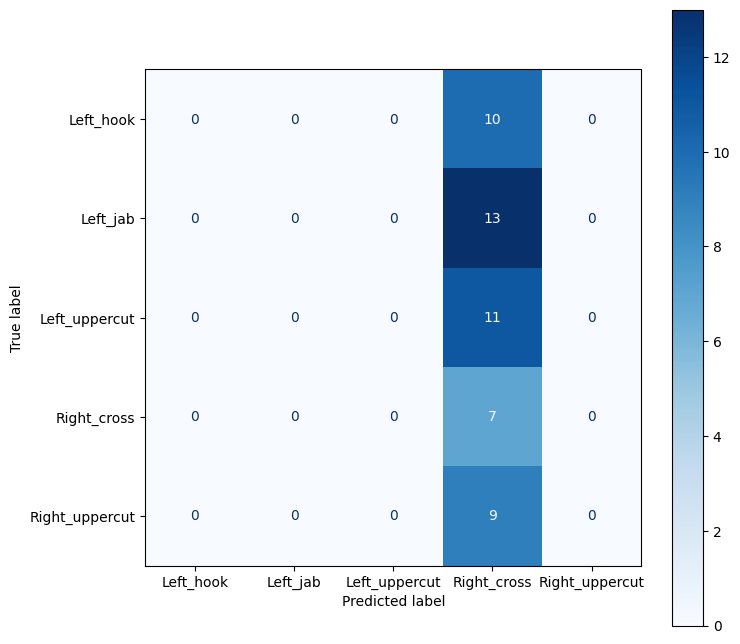

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# confusion matrix is more informative:
matrix = ConfusionMatrixDisplay.from_estimator(
        reg_model,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    )
matrix.figure_.set_size_inches(8,8)

Well, this is really bad. However logistic regression could overslimplify all the problem, so I would go further and check other machine learning algorithms as well.

I would go on with Support Vector Machine (SVM). First I use linear, then non-linear kernels

In [ ]:
from sklearn import svm

clf=svm.SVC(kernel='linear') # first: linear kernel is used here
results_svml=cross_validate(clf,X_train,y_train,cv=10,scoring='accuracy')

print("results:", results_svml['test_score'])
print("mean score:", np.mean(results_svml['test_score']))
print("standardd deviation:", np.std(results_svml['test_score']))
clf.fit(X_train,y_train)

accuracy_score(clf.predict(X_test),y_test)

results: [0.2  0.25 0.25 0.25 0.2  0.2  0.2  0.2  0.2  0.2 ]
mean score: 0.215
standardd deviation: 0.022912878474779193


0.14

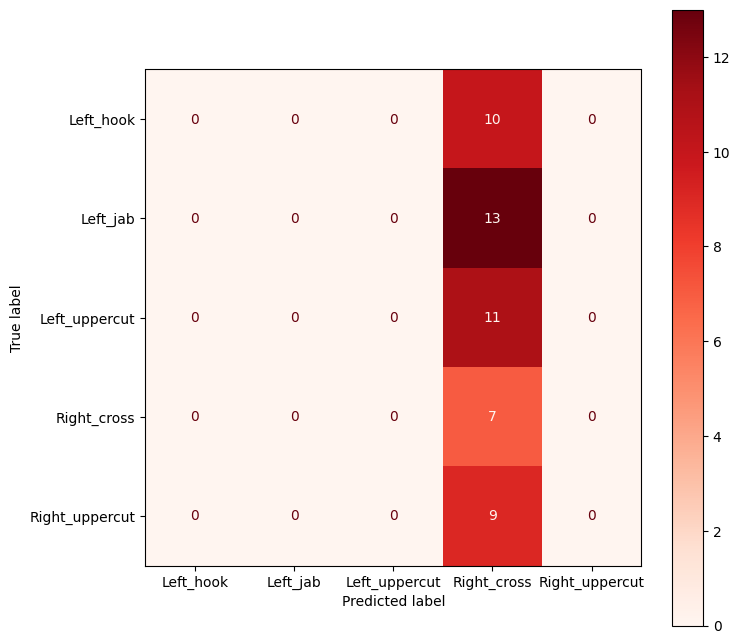

In [ ]:
# confusion matrix is more informative:
matrix1 = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Reds,
    )
matrix1.figure_.set_size_inches(8,8)

This seems to be the same accuracy, however this is linear kernel and hence similar to regression. Let's try nonlinear kernel

results: [0.2  0.25 0.25 0.25 0.2  0.2  0.2  0.2  0.2  0.2 ]
mean score: 0.215
standardd deviation: 0.022912878474779193
accuracy score: 0.14


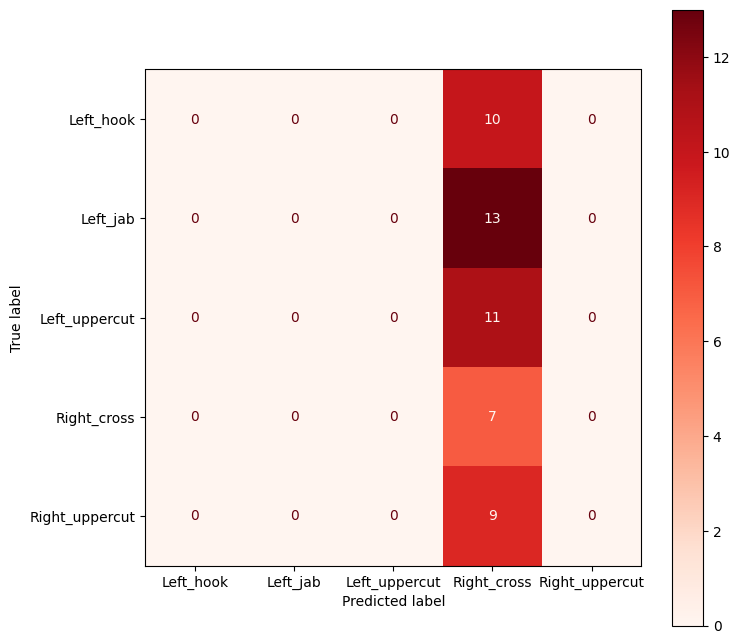

In [ ]:
from sklearn import svm

clf_p=svm.SVC(kernel='poly') # nonlinear kernel
results_p=cross_validate(clf_p,X_train,y_train,cv=10,scoring='accuracy')

print("results:", results_p['test_score'])
print("mean score:", np.mean(results_p['test_score']))
print("standardd deviation:", np.std(results_p['test_score']))
clf_p.fit(X_train,y_train)

print("accuracy score:",accuracy_score(clf_p.predict(X_test),y_test))

# confusion matrix is more informative:
matrix1 = ConfusionMatrixDisplay.from_estimator(
        clf_p,
        X_test,
        y_test,
        cmap=plt.cm.Reds,
    )
matrix1.figure_.set_size_inches(8,8)

What we can see here is that Logistic regression and svm is not good in multiclass problems. I can try to play with one vs rest method to have a kind of binary classification:

results: [0.84210526 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368
 0.78947368 0.83333333 0.83333333 0.83333333]
mean score: 0.8078947368421051
standardd deviation: 0.022688626590136075
accuracy score: 0.7777777777777778


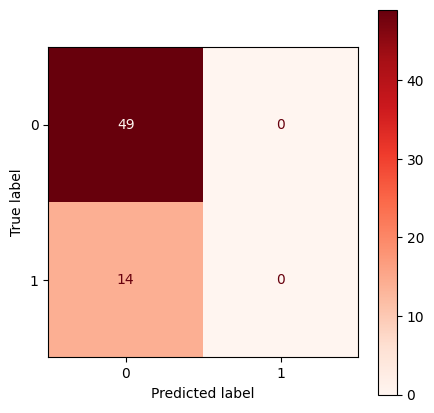

In [ ]:
# 1 will represent my Left_hook label and 0 the rest:
y_one_rest = pd.DataFrame(np.where(df_y['Training_session']=="Left_hook", 1, 0), columns=['Training_session'])
#split data again... I change the test size so that I will not mess up this data set with the multilabeled one:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(inputData, y_one_rest, test_size=0.25, random_state=42)

clf_p_1=svm.SVC(kernel='poly') # nonlinear kernel
results_pr=cross_validate(clf_p_1, X_train_r, y_train_r, cv=10, scoring='accuracy')

print("results:", results_pr['test_score'])
print("mean score:", np.mean(results_pr['test_score']))
print("standardd deviation:", np.std(results_pr['test_score']))
clf_p_1.fit(X_train_r,y_train_r)

print("accuracy score:",accuracy_score(clf_p_1.predict(X_test_r),y_test_r))

# confusion matrix is more informative:
matrix1 = ConfusionMatrixDisplay.from_estimator(
        clf_p_1,
        X_test_r,
        y_test_r,
        cmap=plt.cm.Reds,
    )
matrix1.figure_.set_size_inches(5,5)

It seems our result got much better than previous results, but still not good enough. In the next step I try Radial Basis Function kernel, but this time I would like to try to plot our hyperplane and support vectors.

results: [0.84210526 0.78947368 0.78947368 0.78947368 0.78947368 0.78947368
 0.78947368 0.83333333 0.83333333 0.83333333]
mean score: 0.8078947368421051
standardd deviation: 0.022688626590136075
0.8074866310160428


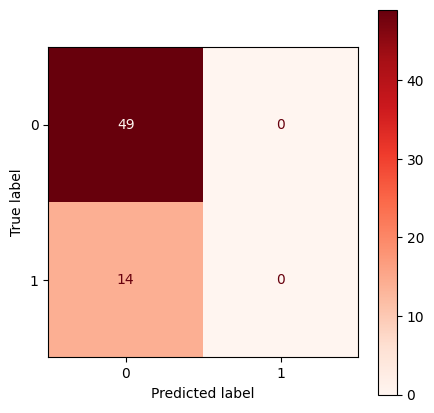

In [ ]:
from sklearn import svm

clf_G = svm.SVC(kernel='rbf') # Gaussian rbf kernel, suggested by The article
#For plotting the results let's reduce manually the dimension of input data: mean of x acceleration of left wrist sensor and the same for T3 sensor
X = X_train_r[['Ax_mean_x', 'Ax_mean']].values
y = y_train_r['Training_session'].values
results_G = cross_validate(clf_G, X, y, cv=10, scoring='accuracy')

print("results:", results_G['test_score'])
print("mean score:", np.mean(results_G['test_score']))
print("standardd deviation:", np.std(results_G['test_score']))
clf_G.fit(X, y)

print(accuracy_score(clf_G.predict(X), y))
matrix2 = ConfusionMatrixDisplay.from_estimator(
        clf_p_1,
        X_test_r,
        y_test_r,
        cmap=plt.cm.Reds,
    )
matrix2.figure_.set_size_inches(5,5)

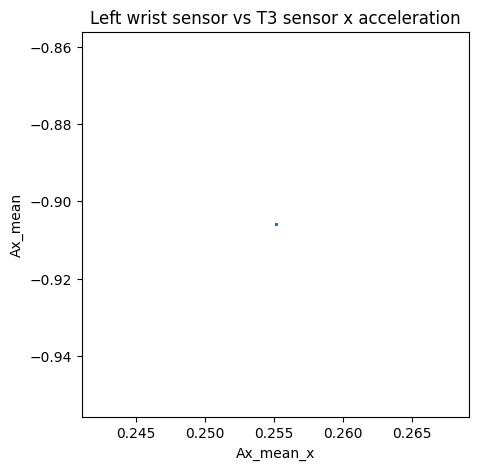

In [ ]:
#first just make a scatter plot of simplified dataset:
X_train_r.plot.scatter('Ax_mean_x', 'Ax_mean', s=1, figsize=(5, 5), title="Left wrist sensor vs T3 sensor x acceleration");

<Axes: >

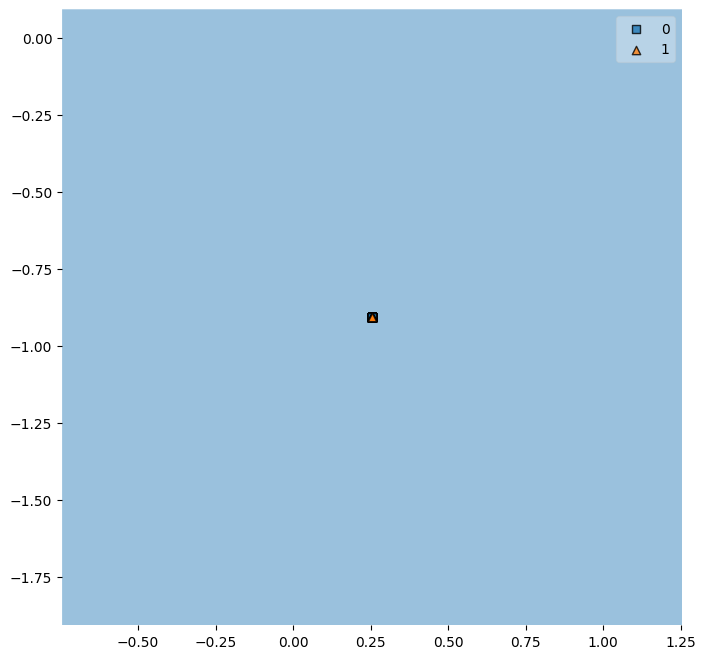

In [ ]:
# This one seems better than the one with 'poly' kernel gave. In this case I might be able to use Sebastian's great descision region from the lecture:
from mlxtend.plotting import plot_decision_regions

plt.figure(figsize=(8,8))
plot_decision_regions(X, y, clf_G, ax=plt.gca())
#plt.gca().set_title(f"$accuracy={decTree.score(X_train_r,y_train_r):.2f}$");

# turns out I can not try it here, as I have too many features, more than 2

So these methods did not really improve results. The next step is to try some decision trees with all types of strikes

In [ ]:
from sklearn.tree import DecisionTreeClassifier
#first try 1 depth of tree
decTree=DecisionTreeClassifier(max_depth=1, random_state=1337)
decTree=clf.fit(X_train,y_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
matrix2 = ConfusionMatrixDisplay.from_estimator(
        decTree,
        X_test,
        y_test,
        cmap=plt.cm.Reds,
    )
matrix2.figure_.set_size_inches(8,8)

In [ ]:
# I might still use one-rest representation for classification:

y_one_rest = pd.DataFrame(np.where(df_y['Training_session']=="Left_hook", 1, 0), columns=['Training_session'])
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(inputData, y_one_rest, test_size=0.2, random_state=42)

decTree=DecisionTreeClassifier(max_depth=1, random_state=1337)
decTree=clf.fit(X_train_r,y_train_r)

matrix2 = ConfusionMatrixDisplay.from_estimator(
        decTree,
        X_test_r,
        y_test_r,
        cmap=plt.cm.Reds,
    )
matrix2.figure_.set_size_inches(8,8)

In [ ]:
# However I can check the decision tree:

decTree3=DecisionTreeClassifier(max_depth=4, random_state=1337)
decTree3=decTree3.fit(X_train,y_train)

from sklearn.tree import plot_tree

fig= plt.figure(figsize=(8,8))
plot_tree(decTree3, feature_names=X_train.columns, class_names=np.unique(y_train.astype(str)));

This is not really working... in this case I would try having only 2 features:

In [ ]:
X = pd.DataFrame(X_train_r[['Ax_mean', 'Gx_mean']], columns=['Ax_mean', 'Gx_mean'])

decTree3=DecisionTreeClassifier(max_depth=4, random_state=1337)
decTree3=decTree3.fit(X,y_train_r)

from sklearn.tree import plot_tree

fig= plt.figure(figsize=(8,8))
plot_tree(decTree3, feature_names=X.columns, class_names=np.unique(y_train_r.astype(str)))
